# Preparación del entorno

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,035 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,339 kB]
Get:13 http://archive.ubuntu.com/ubuntu ja

# Imports

In [ ]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import numpy as np
import math
import pandas as pd
import subprocess
from google.colab import drive
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [ ]:
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors
import numpy as np
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import PCA
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

# Spark Session

In [ ]:
appName = 'abd16_modelo_<sparksql'
spark = SparkSession.builder\
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [ ]:
df = pd.read_csv("datos_EBAY.csv")

data = spark.createDataFrame(df)

data = data\
        .withColumnRenamed("datos_ebay.date", "date")\
        .withColumnRenamed("datos_ebay.ticker", "ticker")\
        .withColumnRenamed("datos_ebay.cik", "cik")\
        .withColumnRenamed("datos_ebay.open", "open")\
        .withColumnRenamed("datos_ebay.high", "high")\
        .withColumnRenamed("datos_ebay.low", "low")\
        .withColumnRenamed("datos_ebay.close", "close")\
        .withColumnRenamed("datos_Ebay.adj_close", "adj_close")\
        .withColumnRenamed("datos_ebay.volume", "volume")\
        .dropna()


data.show()

+----------+------+----------+------------------+------------------+------------------+------------------+------------------+---------+
|      date|ticker|       cik|              open|              high|               low|             close|         adj_close|   volume|
+----------+------+----------+------------------+------------------+------------------+------------------+------------------+---------+
|2018-01-02|  EBAY|0001065088| 38.16999816894531| 38.36000061035156| 37.91999816894531|38.060001373291016| 34.87108612060547|6997300.0|
|2018-01-03|  EBAY|0001065088|  37.9900016784668| 39.27999877929688|37.900001525878906|39.220001220703125| 35.93388748168945|9134400.0|
|2018-01-04|  EBAY|0001065088| 39.41999816894531| 39.77000045776367|38.470001220703125| 38.56999969482422|35.338340759277344|8958600.0|
|2018-01-05|  EBAY|0001065088| 38.84999847412109| 39.84000015258789|38.810001373291016| 39.68999862670898|  36.3645133972168|7290400.0|
|2018-01-08|  EBAY|0001065088| 39.54999923706055

In [ ]:
print(data.columns)

['date', 'ticker', 'cik', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


In [ ]:
windowSpec = Window.orderBy('ticker')

# data_lag = data.withColumn([lag(col_name, 1).over(windowSpec).alias(col_name + "_lagged") for col_name in data.columns])

data_lag = data\
            .withColumn("open_lag", lag(data["open"], 1).over(windowSpec))\
            .withColumn("high_lag", lag(data["high"], 1).over(windowSpec))\
            .withColumn("low_lag", lag(data["open"], 1).over(windowSpec))\
            .withColumn("close_lag", lag(data["close"], 1).over(windowSpec))\
            .withColumn("adj_close_lag", lag(data["open"], 1).over(windowSpec))\
            .withColumn("volume_lag", lag(data["open"], 1).over(windowSpec))\
            .withColumnRenamed("close", "label")\
            .dropna()


data_lag.show()

+----------+------+----------+------------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+------------------+------------------+------------------+
|      date|ticker|       cik|              open|              high|               low|             label|         adj_close|   volume|          open_lag|          high_lag|           low_lag|         close_lag|     adj_close_lag|        volume_lag|
+----------+------+----------+------------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+------------------+------------------+------------------+
|2018-01-03|  EBAY|0001065088|  37.9900016784668| 39.27999877929688|37.900001525878906|39.220001220703125| 35.93388748168945|9134400.0| 38.16999816894531| 38.36000061035156| 38.16999816894531|38.060001373291016| 38.16999816894531| 38.16999816894531|


In [ ]:
features = ["open_lag", "high_lag", "low_lag", "close_lag", "adj_close_lag", "volume_lag"]

In [ ]:
assembler_tr = VectorAssembler(inputCols=features, outputCol="features")

data_assembler = assembler_tr.transform(data_lag)

data_ready = data_assembler.select("label", "features")


data_ready.show()

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
|39.220001220703125|[38.1699981689453...|
| 38.56999969482422|[37.9900016784668...|
| 39.68999862670898|[39.4199981689453...|
| 39.79999923706055|[38.8499984741210...|
| 39.52999877929688|[39.5499992370605...|
| 37.70000076293945|[40.0999984741210...|
|37.810001373291016|[38.8699989318847...|
| 38.02000045776367|[37.8400001525878...|
| 37.68000030517578|[38.0,38.27000045...|
|  37.9900016784668|[38.0699996948242...|
|  38.7400016784668|[38.0,38.31000137...|
| 38.43000030517578|[38.2099990844726...|
| 39.58000183105469|[38.75,39.0200004...|
| 39.77000045776367|[38.3600006103515...|
| 39.81999969482422|[39.5900001525878...|
| 40.02000045776367|[39.9700012207031...|
| 40.88999938964844|[39.9300003051757...|
| 40.79999923706055|[40.3100013732910...|
|40.400001525878906|[40.5900001525878...|
| 40.58000183105469|[40.7200012207031...|
+------------------+--------------

In [ ]:
data_tr = data_ready.limit(data_ready.count() - 7)
data_te = data_ready.exceptAll(data_tr)

In [ ]:
print(data_tr.count())
print(data_ready.count())
print(data_te.count())

1577
1584
7


In [ ]:
data_tr.show()
data_te.show()

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
|39.220001220703125|[38.1699981689453...|
| 38.56999969482422|[37.9900016784668...|
| 39.68999862670898|[39.4199981689453...|
| 39.79999923706055|[38.8499984741210...|
| 39.52999877929688|[39.5499992370605...|
| 37.70000076293945|[40.0999984741210...|
|37.810001373291016|[38.8699989318847...|
| 38.02000045776367|[37.8400001525878...|
| 37.68000030517578|[38.0,38.27000045...|
|  37.9900016784668|[38.0699996948242...|
|  38.7400016784668|[38.0,38.31000137...|
| 38.43000030517578|[38.2099990844726...|
| 39.58000183105469|[38.75,39.0200004...|
| 39.77000045776367|[38.3600006103515...|
| 39.81999969482422|[39.5900001525878...|
| 40.02000045776367|[39.9700012207031...|
| 40.88999938964844|[39.9300003051757...|
| 40.79999923706055|[40.3100013732910...|
|40.400001525878906|[40.5900001525878...|
| 40.58000183105469|[40.7200012207031...|
+------------------+--------------

In [ ]:
# Estimator.
ranforr_es = RandomForestRegressor()
# Transformer.
ranforr_tr = ranforr_es.fit(data_tr)
# Predicción.
pred_ranforr = ranforr_tr.transform(data_te)
# Evaluación.
evaluator = RegressionEvaluator()
print("RMSE: %5.2f" % evaluator.evaluate(pred_ranforr))
print("MSE:  %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "mse"}))
print("R2:   %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "r2"}))
print("MAE:  %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "mae"}))
# Almacenamiento.
ranforr_tr.write().overwrite().save("./Model_ranforr")
# Recuperación.
loaded = RandomForestRegressionModel.load("./Model_ranforr")

pred_ranforr.show()
loaded.transform(data_te).select("prediction").show()

RMSE:  0.70
MSE:   0.49
R2:    0.17
MAE:   0.59
+------------------+--------------------+------------------+
|             label|            features|        prediction|
+------------------+--------------------+------------------+
| 51.88999938964844|[51.9599990844726...|51.939617501022724|
| 50.38999938964844|[51.3300018310546...|  50.9909006801828|
| 49.95000076293945|[50.5900001525878...|50.041807767670086|
| 49.45000076293945|[50.6300010681152...|50.041807767670086|
|             50.25|[51.6199989318847...| 51.35449312503603|
|51.310001373291016|[52.5999984741210...|51.939617501022724|
| 50.88999938964844|[51.7099990844726...|51.939617501022724|
+------------------+--------------------+------------------+

+------------------+
|        prediction|
+------------------+
|51.939617501022724|
|  50.9909006801828|
|50.041807767670086|
|50.041807767670086|
| 51.35449312503603|
|51.939617501022724|
|51.939617501022724|
+------------------+



In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

ranforr = RandomForestRegressor()

# Rejilla.
paramGrid = ParamGridBuilder()\
    .addGrid(ranforr.numTrees, [15, 20, 25]) \
    .addGrid(ranforr.maxDepth, [5, 6, 7])\
    .build()

In [ ]:
from pyspark.ml.tuning import CrossValidator

cv_es = CrossValidator(estimator=ranforr,
                       estimatorParamMaps=paramGrid,
                       evaluator=RegressionEvaluator(metricName="r2"),
                       numFolds=2,
                       seed=4321
                      )

# Transformer.
cv_tr = cv_es.fit(data_tr)

In [ ]:
pred_ranforr_cv = cv_tr.transform(data_te)

In [ ]:
cv_tr.write().overwrite().save("./Model_ranforr_crossValidation")

In [ ]:
for param, value in cv_tr.getEstimatorParamMaps()[np.argmax(cv_tr.avgMetrics)].items():
    print("%-10s %5g" % (param.name + ":", value))

numTrees:     20
maxDepth:      7


In [ ]:
evaluator = RegressionEvaluator()

pred_cv = cv_tr.transform(data_te)
print("R2 (default): %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "r2"}))
print("R2 (tuned):  %5.2f" % evaluator.evaluate(pred_cv, {evaluator.metricName: "r2"}))

R2 (default):  0.17
R2 (tuned):   0.17


In [ ]:
from pyspark.ml.tuning import CrossValidatorModel

loaded_original = RandomForestRegressionModel.load("./Model_ranforr")
loaded_tuned = CrossValidatorModel.load("./Model_ranforr_crossValidation")

pred_ranforr = loaded_original.transform(data_te)
pred_cv = loaded_tuned.transform(data_te)

pred_ranforr_tr = loaded_original.transform(data_tr)
pred_cv_tr = loaded_tuned.transform(data_tr)

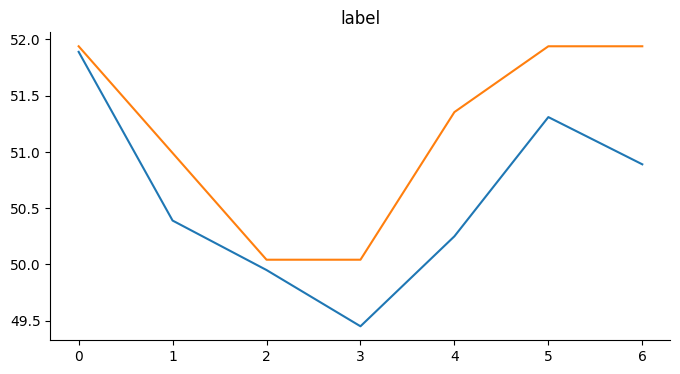

In [ ]:
from matplotlib import pyplot as plt

pred_df = pred_ranforr.toPandas()
label_df = data_te.toPandas()

label_df['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

pred_df['prediction'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

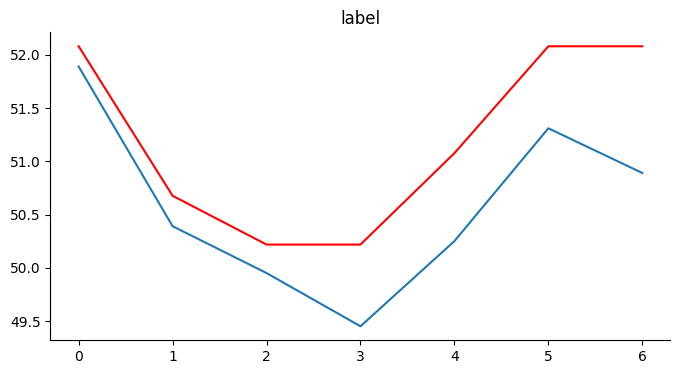

In [ ]:
pred_cv_df = pred_cv.toPandas()

label_df['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

pred_cv_df['prediction'].plot(kind='line', figsize=(8, 4), title='label', color='red')
plt.gca().spines[['top', 'right']].set_visible(False)

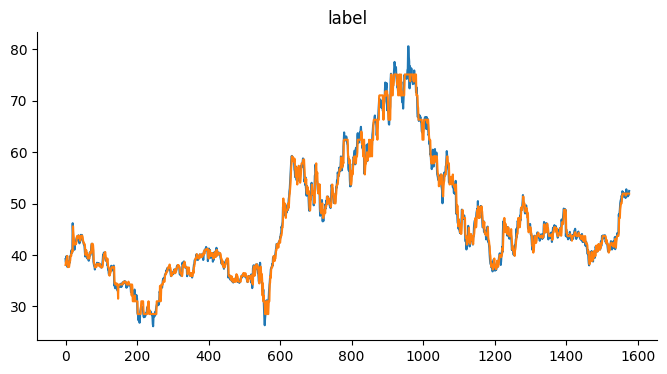

In [ ]:
pred_df_tr = pred_ranforr_tr.toPandas()
label_df_tr = data_tr.toPandas()
pred_df_cv_tr = pred_cv_tr.toPandas()

label_df_tr['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

pred_df_tr['prediction'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

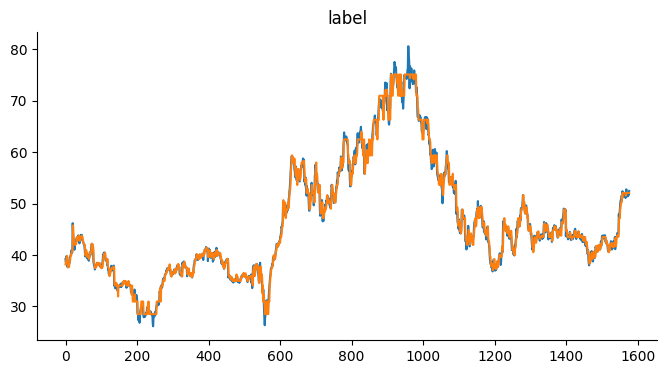

In [ ]:
label_df_tr['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

pred_df_cv_tr['prediction'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
evaluator = RegressionEvaluator()
print("Original RMSE: %5.2f" % evaluator.evaluate(pred_ranforr))
print("TUNED RMSE: %5.2f" % evaluator.evaluate(pred_ranforr_cv))
print("Original MSE:  %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "mse"}))
print("TUNED MSE:  %5.2f" % evaluator.evaluate(pred_ranforr_cv, {evaluator.metricName: "mse"}))
print("Original R2:   %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "r2"}))
print("TUNED R2:   %5.2f" % evaluator.evaluate(pred_ranforr_cv, {evaluator.metricName: "r2"}))
print("Original MAE:  %5.2f" % evaluator.evaluate(pred_ranforr, {evaluator.metricName: "mae"}))
print("TUNED MAE:  %5.2f" % evaluator.evaluate(pred_ranforr_cv, {evaluator.metricName: "mae"}))

Original RMSE:  0.70
TUNED RMSE:  0.70
Original MSE:   0.49
TUNED MSE:   0.50
Original R2:    0.17
TUNED R2:    0.17
Original MAE:   0.59
TUNED MAE:   0.61


In [ ]:
pred_cv_tr = cv_tr.transform(data_tr)

evaluator = RegressionEvaluator()
print("TRAIN RMSE: %5.2f" % evaluator.evaluate(pred_cv_tr))
print("TRAIN MSE:  %5.2f" % evaluator.evaluate(pred_cv_tr, {evaluator.metricName: "mse"}))
print("TRAIN R2:   %5.2f" % evaluator.evaluate(pred_cv_tr, {evaluator.metricName: "r2"}))
print("TRAIN MAE:  %5.2f" % evaluator.evaluate(pred_cv_tr, {evaluator.metricName: "mae"}))

TRAIN RMSE:  1.07
TRAIN MSE:   1.15
TRAIN R2:    0.99
TRAIN MAE:   0.77
